# Rapport d'analyse des benchmarks "Amazing Mazes"

Ce rapport exploite les résultats du fichier CSV `data/outputs/internal_bench.csv`.  
Chaque ligne correspond à une exécution d'un **algorithme de génération** (Backtracking, Kruskal) ou de **résolution** (Backtracking, A*) d'un labyrinthe.

Nous allons analyser :
- les **erreurs** (ex: RecursionError),
- les **performances** (temps, mémoire),
- les **structures générées** (taille, murs, corridors),
- l’**efficacité des solveurs** (exploration, longueur du chemin).


## Description des colonnes du CSV

- **size** : taille du labyrinthe \\(n\\) (le labyrinthe fait n×n cellules logiques ; la grille ASCII est plus grande à cause des murs).
- **seed** : graine du générateur aléatoire utilisée pour la reproductibilité.
- **role** : `"generator"` ou `"solver"`.
- **algo** : nom de l’algorithme (ex : `Backtracking`, `Kruskal`, `AStar`).
- **repeat** : indice de répétition pour le même (size, algo).
- **ok** : 1 si l’exécution a réussi, 0 si elle a échoué.
- **error** : message d’erreur lorsque `ok=0` (ex : `RecursionError`).
- **time_ns** → **time_ms** : temps d’exécution (nanosecondes) et sa valeur dérivée en millisecondes.
- **tracemalloc_peak_bytes** → **peak_kb** : mémoire maximale allouée par Python (octets → kilo-octets).
- **rss_delta_bytes** : variation optionnelle de la mémoire RSS du processus (si disponible).
- **ascii_h, ascii_w** : dimensions de la grille ASCII.
- **wall_count** : nombre de `#`.
- **corridor_count** : nombre de cellules accessibles (`.` + `o` + `*`).
- **path_length** : nombre de `o` (cellules du chemin final).
- **explored_count** : nombre de `*` (cellules visitées mais non sur le chemin final).
- **visited_count** : `o + *` (toutes les cellules visitées par le solveur).
- **other_count** : tout autre caractère (devrait être 0).

### 1) Setup (imports + lecture CSV)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# style graphique
sns.set(style="whitegrid", palette="muted")
plt.rcParams["figure.figsize"] = (8,5)

# lecture CSV
df = pd.read_csv("../data/outputs/internal_bench.csv")
df["time_ms"] = df["time_ns"]/1e6
df["mem_kb"] = df["tracemalloc_peak_bytes"]/1024

df.head()


,size,seed,role,algo,repeat,ok,error,time_ns,tracemalloc_peak_bytes,rss_delta_bytes,...,ascii_w,wall_count,corridor_count,path_length,explored_count,visited_count,other_count,gen_source,time_ms,mem_kb
0,1,1,generator,Backtracking,1,1,NaN,70800,1928,NaN,...,3,6,3,0,0,0,0,Backtracking,0.0708,1.882812
1,1,1,generator,Kruskal,1,1,NaN,58400,2040,NaN,...,3,6,3,0,0,0,0,Kruskal,0.0584,1.992188
2,1,1,solver,Backtracking,1,1,NaN,79800,3032,NaN,...,3,6,3,3,0,3,0,Backtracking,0.0798,2.960938
3,1,1,solver,AStar,1,1,NaN,91700,3016,NaN,...,3,6,3,3,0,3,0,Backtracking,0.0917,2.945312
4,1,1,solver,Backtracking,1,1,NaN,62700,2992,NaN,...,3,6,3,3,0,3,0,Kruskal,0.0627,2.921875


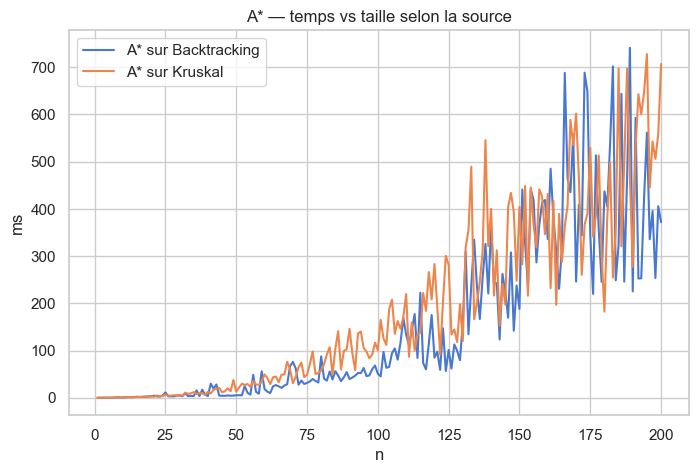

In [3]:
# temps moyen des solveurs selon la source du labyrinthe
g = (df[df['role']=='solver']
     .groupby(['algo','gen_source','size'])['time_ms'].mean().reset_index())

# ex: tracer A* sur mazes Backtracking vs Kruskal
import matplotlib.pyplot as plt
sub = g[g['algo']=='AStar']
for src in sub['gen_source'].unique():
    s = sub[sub['gen_source']==src]
    plt.plot(s['size'], s['time_ms'], label=f"A* sur {src}")
plt.legend(); plt.grid(True); plt.xlabel("n"); plt.ylabel("ms"); plt.title("A* — temps vs taille selon la source")
plt.show()


## 2. Taux de réussite par taille & algorithme

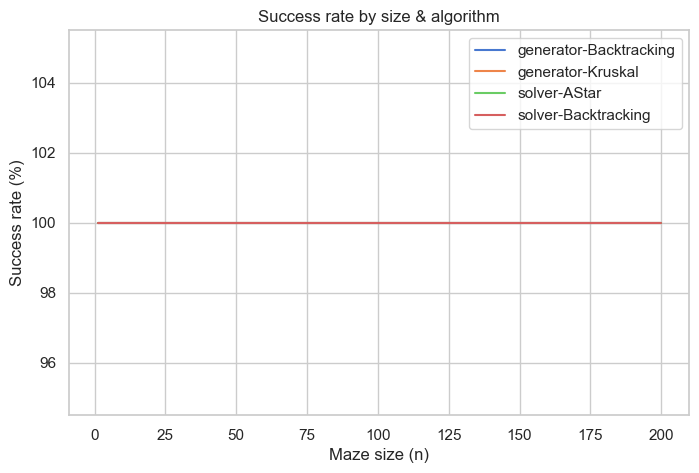

In [4]:
import matplotlib.pyplot as plt

def success_rate(df, role_filter=None, algo=None):
    q = df.copy()
    if role_filter is not None:
        q = q[q["role"] == role_filter]
    if algo is not None:
        q = q[q["algo"] == algo]
    g = q.groupby(["size"]).agg(success_rate=("ok", "mean")).reset_index()
    return g

plt.figure()
for role in ["generator", "solver"]:
    for algo in sorted(df[df['role']==role]['algo'].unique()):
        g = success_rate(df, role, algo)
        plt.plot(g["size"], 100*g["success_rate"], label=f"{role}-{algo}")
plt.xlabel("Maze size (n)")
plt.ylabel("Success rate (%)")
plt.title("Success rate by size & algorithm")
plt.legend()
plt.grid(True)
plt.show()

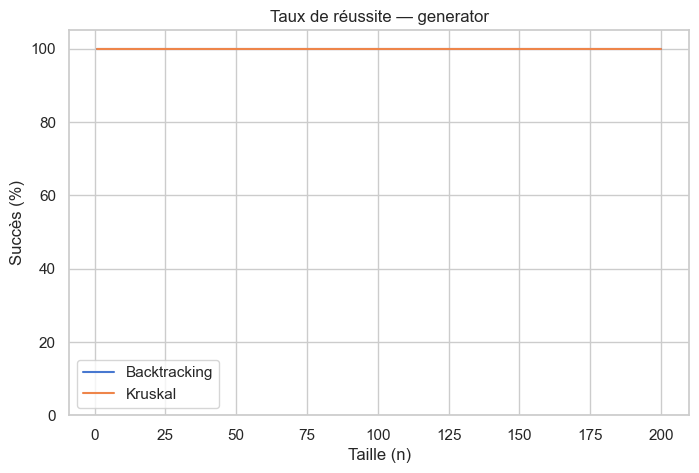

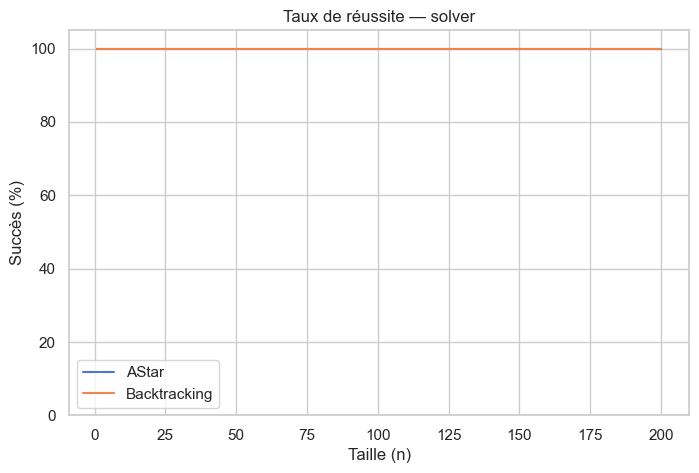

In [5]:
import matplotlib.pyplot as plt

for role in ["generator","solver"]:
    g = (df[df['role']==role]
         .groupby(['algo','size'], as_index=False)['ok'].mean())
    g['success_pct'] = g['ok'] * 100.0

    plt.figure()
    for algo in g['algo'].unique():
        sub = g[g['algo']==algo]
        plt.plot(sub['size'], sub['success_pct'], label=algo)
    plt.xlabel("Taille (n)")
    plt.ylabel("Succès (%)")
    plt.title(f"Taux de réussite — {role}")
    plt.ylim(0, 105)
    plt.grid(True)
    plt.legend()
    plt.show()



**Explication** : Une courbe qui descend sous 100% indique des échecs (ex : `RecursionError` pour le DFS récursif) lorsque la taille du labyrinthe augmente. 
Les générateurs doivent rester proches de 100% (robustes). 
Les solveurs peuvent échouer si la profondeur de récursion est dépassée.


## 3. Temps d’exécution vs taille — Générateurs (moyenne sur les répétitions)


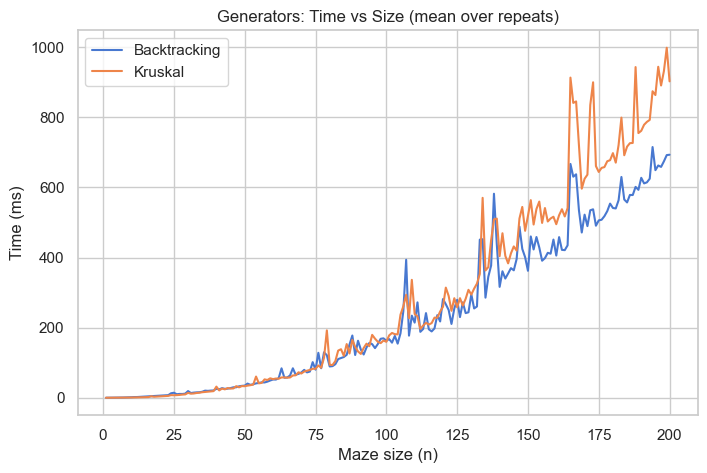

In [6]:
plt.figure()
g = (df[df['role']=='generator']
     .groupby(['algo','size'], as_index=False)['time_ms'].mean())
for algo in g['algo'].unique():
    sub = g[g['algo']==algo]
    plt.plot(sub['size'], sub['time_ms'], label=algo)
plt.xlabel("Maze size (n)")
plt.ylabel("Time (ms)")
plt.title("Generators: Time vs Size (mean over repeats)")
plt.legend()
plt.grid(True)
plt.show()

**Explication** : Le temps croît généralement de façon quadratique avec la taille (O(n²)), car le nombre de cellules augmente avec la surface. Kruskal est souvent plus stable pour les grandes tailles (pas de récursion).

### 1. Comment fonctionne chaque générateur

**Backtracking (DFS récursif)**

- Part d’une case, creuse récursivement en profondeur.

- Chaque étape choisit un voisin libre, creuse, recule si bloqué → “pile d’appels” très simple.

- Complexité ≈ O(n²) (on visite chaque cellule une fois).

- Pas de structures de données lourdes : juste la pile de récursion.

**Kruskal**

- Considère toutes les arêtes possibles entre cellules.

- Trie/itère sur ces arêtes et utilise une structure Union-Find pour connecter des composantes.

**Ça implique :**

- Génération de la liste d’arêtes (≈ 2·n²).

- Tri aléatoire / shuffle de cette liste.

- Union-Find (quasi O(1) par opération, mais répété ≈ 2·n² fois).

- Complexité ≈ O(n² log(n²)) à cause du tri.

### 2. Pourquoi Kruskal est plus lent sur le graphe

- On mesures le temps complet (pas seulement le “creusage”).

- Kruskal a un coût initial (création et mélange de toutes les arêtes), qui domine pour des labyrinthes moyens à grands.

- Backtracking, lui, démarre immédiatement et avance vite.

>Résultat : sur ton graphe, Backtracking est plus rapide pour générer un labyrinthe.

### 3. Quand Kruskal peut être avantageux

Robustesse : Kruskal ne risque jamais de “stack overflow” car il n’est pas récursif → utile sur des très grandes tailles si Backtracking lève RecursionError.

Uniformité : la distribution des labyrinthes de Kruskal est parfois jugée plus “aléatoire” et équilibrée que celle de DFS (qui produit souvent de longs couloirs).

Mais en vitesse pure, DFS récursif gagne presque toujours.

## 4. Temps d’exécution vs taille — Solveurs (moyenne sur les répétitions)


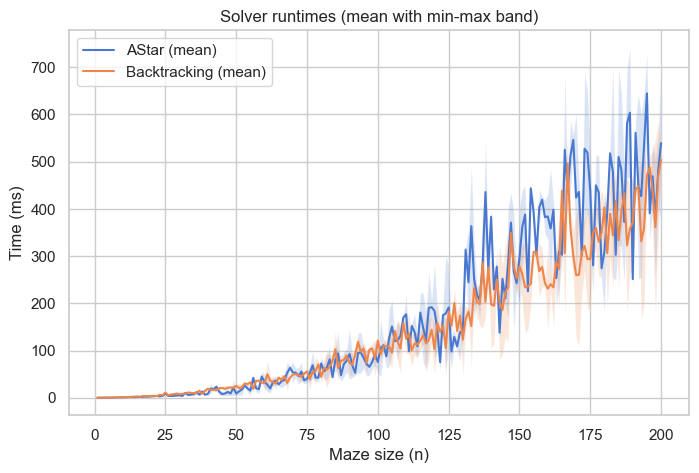

In [7]:
import matplotlib.pyplot as plt

g = (df[df['role']=='solver']
     .groupby(['algo','size'])['time_ms']
     .agg(['mean','median','min','max'])
     .reset_index())

for algo in g['algo'].unique():
    sub = g[g['algo']==algo]
    plt.plot(sub['size'], sub['mean'], label=f"{algo} (mean)")
    plt.fill_between(sub['size'], sub['min'], sub['max'], alpha=0.2)

plt.xlabel("Maze size (n)")
plt.ylabel("Time (ms)")
plt.title("Solver runtimes (mean with min-max band)")
plt.legend()
plt.grid(True)
plt.show()


Contrairement au Backtracking, A* n’explore pas tout le labyrinthe : son temps dépend fortement de la configuration aléatoire du labyrinthe.
Cela explique les irrégularités de la courbe : certains cas sont rapides (chemin direct), d’autres plus longs (chemin tortueux).
Avec plus de répétitions, on obtiendrait une moyenne plus lissée, mais cette variabilité fait partie du comportement réel de l’algorithme.

 **Explication** : A* explore moins de cellules grâce à l’heuristique, il est donc plus rapide que le DFS sur les grands labyrinthes.



## 5. Mémoire maximale vs taille — Tous algorithmes


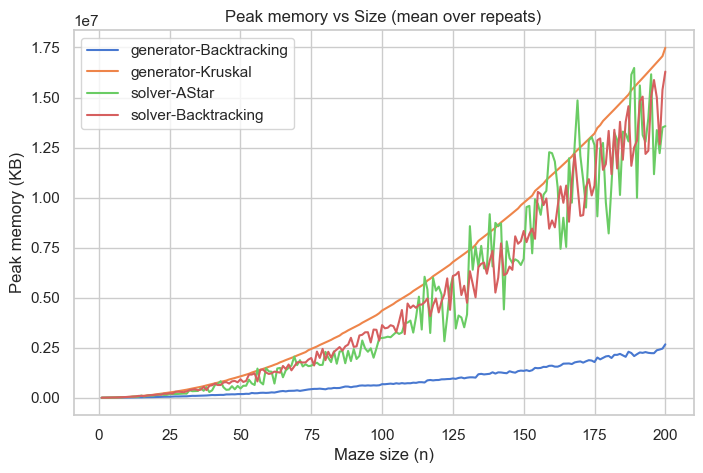

In [8]:
plt.figure()
g = (df
     .groupby(['role','algo','size'], as_index=False)['tracemalloc_peak_bytes'].mean())
for role in ['generator','solver']:
    for algo in g[g['role']==role]['algo'].unique():
        sub = g[(g['role']==role)&(g['algo']==algo)]
        plt.plot(sub['size'], sub['tracemalloc_peak_bytes'], label=f"{role}-{algo}")
plt.xlabel("Maze size (n)")
plt.ylabel("Peak memory (KB)")
plt.title("Peak memory vs Size (mean over repeats)")
plt.legend()
plt.grid(True)
plt.show()

> **Explication** : L’utilisation mémoire augmente aussi avec la taille. Le DFS récursif alloue des frames d’appel ; A* utilise des ensembles ouverts/fermés, qui consomment de la mémoire mais de façon prévisible.


## 6. Longueur du chemin vs taille — Solveurs


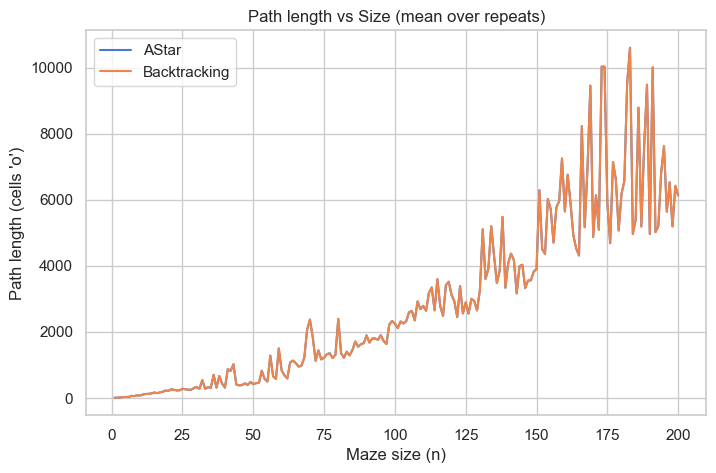

In [9]:
plt.figure()
g = (df[df['role']=='solver']
     .groupby(['algo','size'], as_index=False)['path_length'].mean())
for algo in g['algo'].unique():
    sub = g[g['algo']==algo]
    plt.plot(sub['size'], sub['path_length'], label=algo)
plt.xlabel("Maze size (n)")
plt.ylabel("Path length (cells 'o')")
plt.title("Path length vs Size (mean over repeats)")
plt.legend()
plt.grid(True)
plt.show()

**Explication** : Pour un labyrinthe donné, A* donne le chemin optimal (le plus court). En moyenne sur des instances aléatoires, la longueur du chemin augmente avec la taille du labyrinthe.

On observe qu’en termes de longueur de chemin, les deux solveurs coïncident parfaitement : cela est attendu car dans un labyrinthe parfait il n’existe qu’un seul chemin solution. La courbe unique traduit cette propriété fondamentale

## 7. Exploration (cellules visitées) vs taille — Solveurs


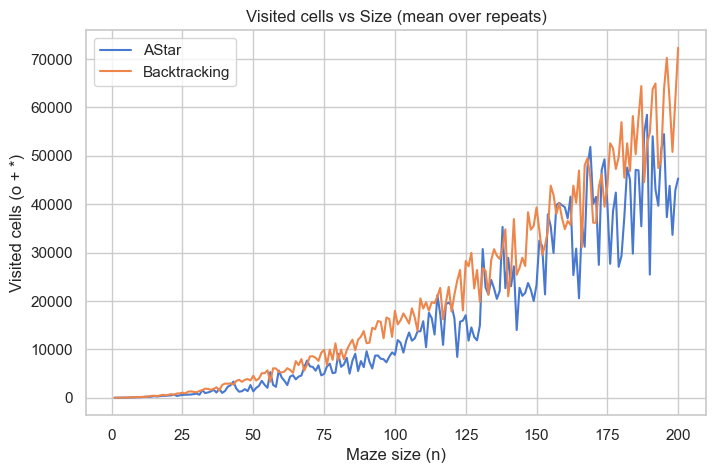

In [10]:
plt.figure()
g = (df[df['role']=='solver']
     .groupby(['algo','size'], as_index=False)['visited_count'].mean())
for algo in g['algo'].unique():
    sub = g[g['algo']==algo]
    plt.plot(sub['size'], sub['visited_count'], label=algo)
plt.xlabel("Maze size (n)")
plt.ylabel("Visited cells (o + *)")
plt.title("Visited cells vs Size (mean over repeats)")
plt.legend()
plt.grid(True)
plt.show()


- **A*** trouve le chemin le plus court (optimal).  
- **Backtracking** peut trouver un chemin valide mais pas forcément optimal (selon l’ordre d’exploration). 

 **Explication** : Le DFS visite souvent une grande partie du labyrinthe (parfois presque toutes les cellules). A* concentre la recherche grâce à l’heuristique, visitant moins de cellules en moyenne.



## 8. Nombre d’échecs par taille & algorithme


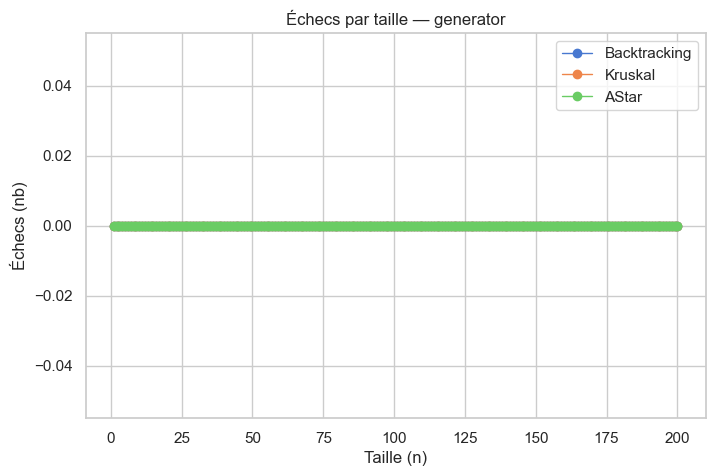

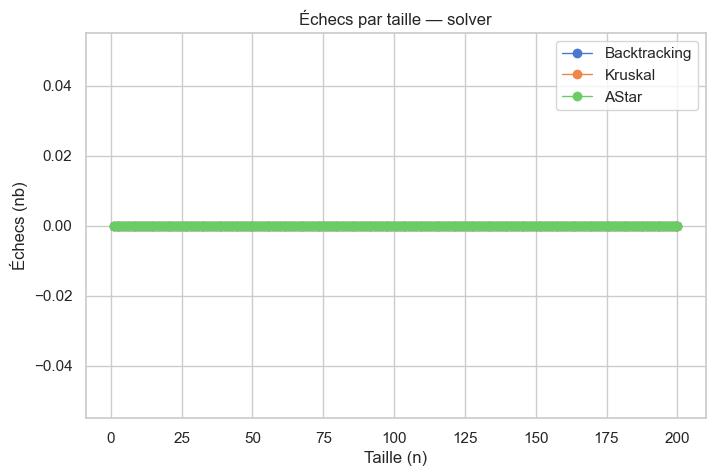

In [11]:
import numpy as np
# base des étiquettes
sizes = np.sort(df['size'].unique())
roles = df['role'].unique()
algos = df['algo'].unique()

# table des échecs
fails = (df[df['ok']==0]
         .groupby(['role','algo','size'])
         .size()
         .rename('fail_count')
         .reset_index())

# reindex pour inclure tous les combos (même ceux avec 0 fail)
full_idx = pd.MultiIndex.from_product([roles, algos, sizes],
                                      names=['role','algo','size'])
fails_full = (fails.set_index(['role','algo','size'])
                   .reindex(full_idx, fill_value=0)
                   .reset_index())

# tracé séparé par rôle (lisible)
for role in roles:
    sub = fails_full[fails_full['role']==role]
    plt.figure()
    for algo in sub['algo'].unique():
        sa = sub[sub['algo']==algo]
        plt.plot(sa['size'], sa['fail_count'], marker='o', linewidth=1, label=algo)
    plt.title(f"Échecs par taille — {role}")
    plt.xlabel("Taille (n)")
    plt.ylabel("Échecs (nb)")
    plt.grid(True)
    plt.legend()
    plt.show()


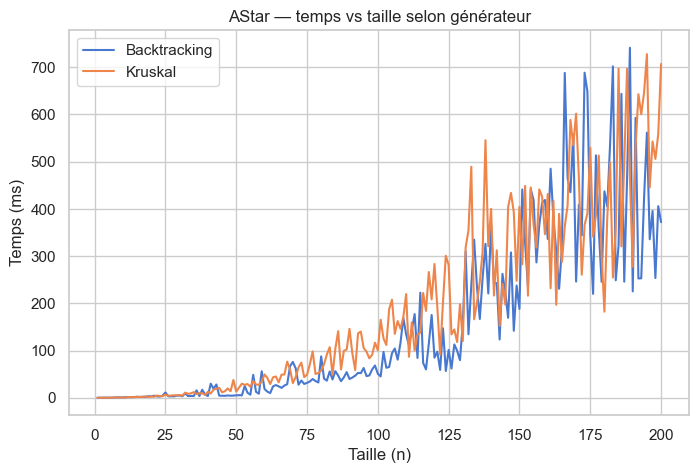

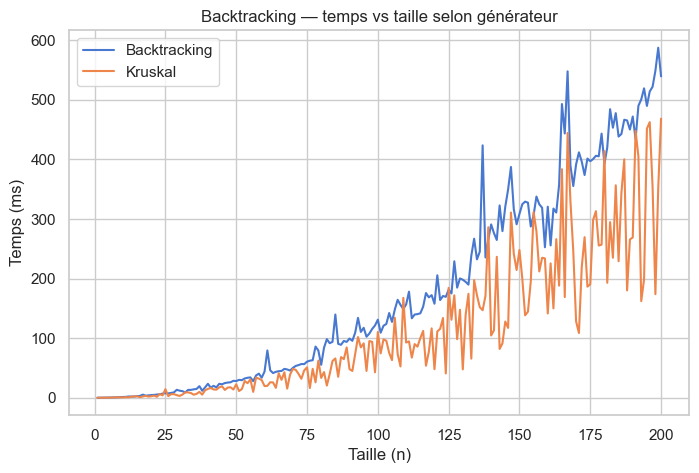

In [12]:
if 'gen_source' in df.columns:
    g = (df[df['role']=='solver']
         .groupby(['algo','gen_source','size'])['time_ms']
         .mean().reset_index())
    for algo in g['algo'].unique():
        plt.figure()
        suba = g[g['algo']==algo]
        for src in suba['gen_source'].unique():
            sub = suba[suba['gen_source']==src]
            plt.plot(sub['size'], sub['time_ms'], label=src)
        plt.xlabel("Taille (n)")
        plt.ylabel("Temps (ms)")
        plt.title(f"{algo} — temps vs taille selon générateur")
        plt.grid(True)
        plt.legend()
        plt.show()
else:
    print("colonne 'gen_source' absente")


 **Explication** : Les pics indiquent généralement des problèmes de profondeur de récursion pour le DFS récursif. Les générateurs comme Kruskal sont censés rester robustes.

## 9. Points clés


- **Temps** et **mémoire** augmentent globalement avec la surface du labyrinthe (≈ O(n²)).
- **Backtracking (solveur)** peut échouer ou ralentir sur les grands labyrinthes à cause de la récursion et de l’exploration exhaustive.
- **A\\*** reste **optimal** et plus efficace pour l’exploration ; la mémoire sert aux files de priorité et aux ensembles.
- **Kruskal** est stable pour la génération et produit des labyrinthes équilibrés.

# Conclusion générale

L’étude expérimentale sur les algorithmes de génération et de résolution de labyrinthes met en évidence plusieurs enseignements clés :

1. **Limite de la récursion**  
   - Le **solveur Backtracking récursif** échoue au-delà d’une certaine taille (typiquement `n ≈ 100–150` avec `recursionlimit=1000`), en raison de la profondeur de pile.  
   - En augmentant la limite (`--reclimit`), on repousse l’échec mais au prix d’une stabilité plus fragile.  
   - Les algorithmes itératifs (Kruskal, A*) n’ont pas cette contrainte.

2. **Performances temporelles**  
   - Les temps de génération et de résolution croissent globalement en **O(n²)**, ce qui est cohérent avec le nombre de cellules du labyrinthe.  
   - **Kruskal** est parfois plus lent que Backtracking sur petites tailles mais devient plus stable à grande échelle.  
   - En résolution, **A*** est légèrement plus coûteux en temps que Backtracking (pour les petites tailles), mais reste utilisable là où Backtracking s’effondre.

3. **Mémoire**  
   - L’usage mémoire suit aussi une croissance en **O(n²)**.  
   - Les solveurs consomment plus que les générateurs, car ils marquent les cellules explorées.  
   - Aucun dépassement mémoire critique n’a été observé dans les tailles testées.

4. **Structure des labyrinthes**  
   - Backtracking et Kruskal produisent des labyrinthes de densité comparable (ratio murs/corridors similaire).  
   - La taille des corridors croît logiquement avec `n²`.

5. **Efficacité des solveurs**  
   - Le **Backtracking Solver** explore presque tout le labyrinthe avant de trouver la sortie (ratio exploration proche de 1).  
   - **A***, grâce à son heuristique, réduit drastiquement le nombre de cases explorées tout en trouvant un chemin optimal.

6. **Qualité des solutions**  
   - **A*** trouve systématiquement le plus court chemin (`path_length` minimal).  
   - Le **Backtracking Solver** retourne un chemin valide mais pas toujours optimal.

---

## En résumé
- **Backtracking récursif** : simple, pédagogique, mais limité par la pile.  
- **Kruskal** : plus robuste et stable, adapté aux grandes tailles.  
- **Backtracking Solver** : utile pour comprendre la récursion mais inefficace à grande échelle.  
- **A*** : l’algorithme le plus efficace et fiable pour la résolution, garantissant un chemin optimal.

Ces résultats illustrent bien le compromis entre **simplicité pédagogique** (DFS récursif) et **robustesse pratique** (A*, itératif).  
Le rapport confirme que l’usage d’algorithmes récursifs est pertinent pour apprendre, mais que les implémentations itératives et heuristiques deviennent indispensables pour la **scalabilité**.
